In [1]:
%load_ext autoreload
%autoreload 2

import os
import glob
import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks

import music21

from transformer_utils import (
    parse_midi_files,
    load_parsed_files,
    get_midi_note,
    SinePositionEncoding,
)

2025-06-18 22:03:28.266640: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-18 22:03:28.273930: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750251808.281588   70081 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750251808.283977   70081 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750251808.290342   70081 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
PARSE_MIDI_FILES = True
PARSED_DATA_PATH = "parsed_data/"
DATASET_REPETITIONS = 1

SEQ_LEN = 50
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 5
DROPOUT_RATE = 0.3
FEED_FORWARD_DIM = 256
LOAD_MODEL = False

# optimization
EPOCHS = 5000
BATCH_SIZE = 256

GENERATE_LEN = 50

In [4]:
# Load the data
file_list = glob.glob("data/*.mid")
print(f"Found {len(file_list)} midi files")

Found 36 midi files


In [5]:
parser = music21.converter

In [6]:
example_score = (
    music21.converter.parse(file_list[1]).splitAtQuarterLength(12)[0].chordify()
)

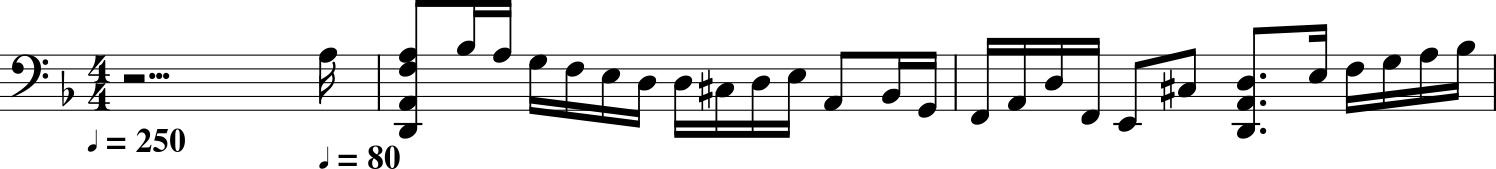

In [9]:
example_score.show()

In [10]:
example_score.show("text")

{0.0} <music21.metadata.Metadata object at 0x76f722e269e0>
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Violoncello 'Solo Cello: Solo Cello'>
    {0.0} <music21.instrument.Violoncello 'Violoncello'>
    {0.0} <music21.clef.BassClef>
    {0.0} <music21.tempo.MetronomeMark Quarter=250>
    {0.0} <music21.key.Key of F major>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Rest 3.75ql>
    {3.75} <music21.tempo.MetronomeMark andantino Quarter=80>
    {3.75} <music21.chord.Chord A3>
{4.0} <music21.stream.Measure 2 offset=4.0>
    {0.0} <music21.chord.Chord D2 A2 F3 A3>
    {0.5} <music21.chord.Chord B-3>
    {0.75} <music21.chord.Chord A3>
    {1.0} <music21.chord.Chord G3>
    {1.25} <music21.chord.Chord F3>
    {1.5} <music21.chord.Chord E3>
    {1.75} <music21.chord.Chord D3>
    {2.0} <music21.chord.Chord D3>
    {2.25} <music21.chord.Chord C#3>
    {2.5} <music21.chord.Chord D3>
    {2.75} <music21.chord.Chord E3>
    {3.0} <music21.chor

In [11]:
if PARSE_MIDI_FILES:
    notes, durations = parse_midi_files(
        file_list, parser, SEQ_LEN + 1, PARSED_DATA_PATH
    )
else:
    notes, durations = load_parsed_files()


1 Parsing data/cs6-6gig.mid


/tmp/ipykernel_70081/1308860806.py:2: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  notes, durations = parse_midi_files(


1172 notes parsed
2 Parsing data/cs2-2all.mid
1865 notes parsed
3 Parsing data/cs5-2all.mid
2557 notes parsed
4 Parsing data/cs4-2all.mid
3612 notes parsed
5 Parsing data/cs4-6gig.mid
4583 notes parsed
6 Parsing data/cs5-4sar.mid
4802 notes parsed
7 Parsing data/cs1-3cou.mid
5622 notes parsed
8 Parsing data/cs4-5bou.mid
6946 notes parsed
9 Parsing data/cs3-2all.mid
7683 notes parsed
10 Parsing data/cs2-1pre.mid
8321 notes parsed
11 Parsing data/cs1-5men.mid
8968 notes parsed
12 Parsing data/cs1-2all.mid
9889 notes parsed
13 Parsing data/cs6-4sar.mid
10224 notes parsed
14 Parsing data/cs6-2all.mid
10909 notes parsed
15 Parsing data/cs2-5men.mid
11436 notes parsed
16 Parsing data/cs5-1pre.mid
12745 notes parsed
17 Parsing data/cs1-1pre.mid
13403 notes parsed
18 Parsing data/cs2-3cou.mid
14144 notes parsed
19 Parsing data/cs4-4sar.mid
14464 notes parsed
20 Parsing data/cs3-6gig.mid
15425 notes parsed
21 Parsing data/cs2-4sar.mid
15762 notes parsed
22 Parsing data/cs3-4sar.mid
16103 notes 

In [12]:
example_notes = notes[658]
example_durations = durations[658]
print("\nNotes string\n", example_notes, "...")
print("\nDuration string\n", example_durations, "...")


Notes string
 D3 C#3 D3 E3 F#3 F#3 E3 F#3 G3 A3 A3 B3 A3 G3 A3 F#3 A2 B2 C#3 D3 E3 F#3 G3 A3 B3 C4 D4 B3 A3 B3 E3 F#3 G3 E3 C#3 B2 C#3 D3 E3 A2 G2 F#2 G2 E2 F#2 A3 G3 F#3 E3 D3 E3 ...

Duration string
 0.25 0.25 0.25 0.25 0.5 0.25 0.25 0.25 0.25 0.5 0.5 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.5 0.5 0.5 0.25 0.25 0.5 0.5 0.25 0.25 0.25 0.25 0.5 0.5 0.25 0.25 0.25 0.25 0.5 0.25 0.25 0.25 0.25 0.25 0.25 ...
